In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

In [36]:
data_dir = '/home/roy/neural/box'

#transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
#mean is subtracted and standard deviation is divided

# Passing  transforms 
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=3, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=3,shuffle=True)
#batch size is less because the dataset is too small

classes = ['blue', 'green', 'red']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


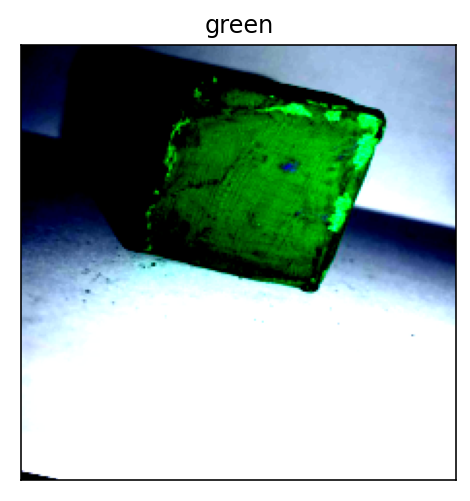

In [37]:


# one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1,1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))#transposing according to imshow format of input
    ax.set_title(classes[labels[idx]])

In [4]:
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [38]:
#GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
#_inputs = model.classifier[6].in_features

#last_layer = nn.Linear(n_inputs, len(classes))
last_layer = nn.Sequential(nn.Linear(9216, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                           nn.Linear(256, 100),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(100, 3),
                                 nn.LogSoftmax(dim=1))# log after applying softmax
model.classifier = last_layer

#print(model.classifier[4].out_features)
print(model)

criterion = nn.NLLLoss() # negative log likelihood 

# train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
#RMS prop+momentum

model.to(device);

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, i

In [42]:
import time
epochs = 20
steps = 0
running_loss = 0
train_losses, test_losses,accuracy_acc = [], [],[]
start = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        #input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # clears any previous gradients
        
        logps = model.forward(inputs) # feed forward
        
        loss = criterion(logps, labels) #calculate loss
        
        loss.backward()  #do back prop
        
        optimizer.step() #update parameters

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                    
                test_loss += batch_loss.item()
                    
                # Cal accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracy_acc.append(accuracy/len(testloader))
                    
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        running_loss = 0
        model.train()
print("Time required: "+str(time.time() - start)+" seconds")

Epoch: 1/20..  Training Loss: 0.097..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 2/20..  Training Loss: 0.301..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 3/20..  Training Loss: 0.233..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 4/20..  Training Loss: 0.002..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 5/20..  Training Loss: 0.000..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 6/20..  Training Loss: 0.000..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 7/20..  Training Loss: 0.214..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 8/20..  Training Loss: 0.025..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 9/20..  Training Loss: 0.001..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 10/20..  Training Loss: 0.006..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 11/20..  Training Loss: 0.018..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 12/20..  Training Loss: 0.032..  Test Loss: 0.000..  Test Accuracy: 1.000
Epoch: 13/20..  Training Loss: 0.000.

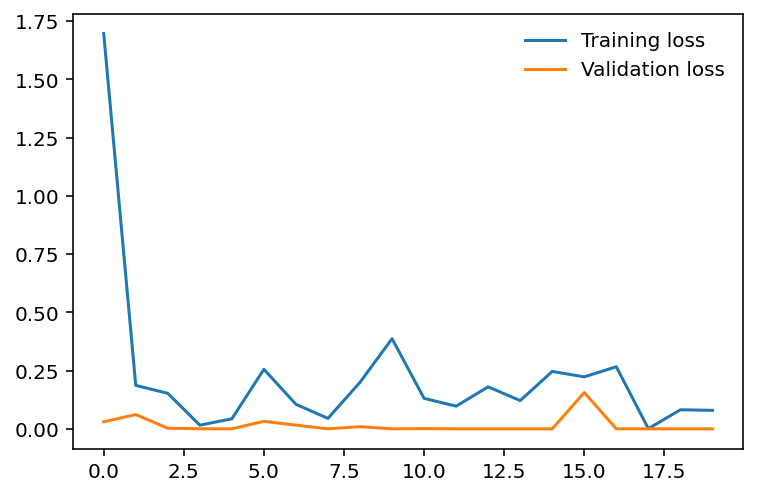

In [40]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

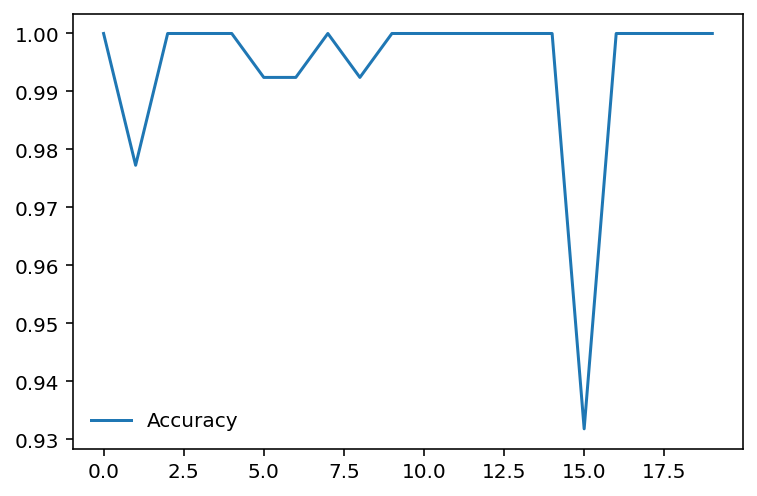

In [41]:
plt.plot(accuracy_acc, label='Accuracy')
plt.legend(frameon=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-21.0462,   0.0000, -39.5960]], grad_fn=<LogSoftmaxBackward>)
tensor([1])
1
Prediciton green
True class green


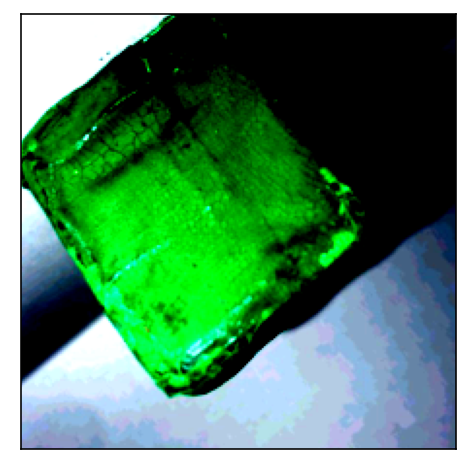

In [35]:
# obtaining one batch of test images
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)

dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    images = images.cuda()

# getting sample outputs
output = model(images)
print(output)
# converting output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
print(preds_tensor)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
#remove single dimensional entries
print(preds)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(1):
    ax = fig.add_subplot(1, 1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    print("Prediciton "+classes[preds])
    print("True class "+classes[labels])
    